In [63]:
import import_ipynb
import cnn_genre_classifier as mgr
import IPython.display as ipd
import librosa
import numpy as np
import soundfile as sf
import torch
import torch.nn.functional as f
from captum.attr import IntegratedGradients

In [4]:
dataset = torch.load("./data/feature_sets/spectro10_normalized.pth")
X_train = dataset['X_train']
X_validation = dataset['X_validation']
X_test = dataset['X_test']
y_train = dataset['y_train']
y_validation = dataset['y_validation']
y_test = dataset['y_test']
scale_min = dataset['scale_min']
scale_max = dataset['scale_max']

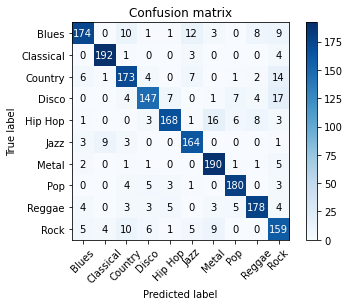

In [5]:
model = mgr.load_model("./data/saved_models/model-spectro10-epoch15-batch64_512-norm.pth")
model_predictions = model.get_predictions(X_test)
matrix = mgr.create_confusion_matrix(model_predictions, y_test)
mgr.plot_confusion_matrix(matrix)

matrix = matrix.numpy()
true_pos = np.diag(matrix)
false_pos = np.sum(matrix, axis=0) - true_pos
false_neg = np.sum(matrix, axis=1) - true_pos

precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

In [69]:
for index, (p, q) in enumerate(zip(model_predictions.argmax(dim=1).type(torch.LongTensor), y_test.type(torch.LongTensor))):
    if (q == 4 and p == 6):
        print(index)

265
314
419
455
692
718
759
860
919
945
1110
1156
1310
1414
1673
1850


In [81]:
X_db = mgr.unscale_input(X_test[1466][0], scale_min, scale_max).numpy()
X_amplitude = librosa.db_to_amplitude(X_db)
reconstruction = librosa.griffinlim(X_amplitude, hop_length=512, win_length=1024)

model = mgr.load_model("./data/saved_models/model-spectro10-epoch15-batch64_512-norm.pth").cpu().eval()
output = model(X_test[1466].unsqueeze(0))
prediction = torch.argmax(output)
print(f.softmax(output, dim=1), prediction)

ipd.Audio(reconstruction, rate=22050)
# sf.write("./results/sample_original.wav", reconstruction, 22050)

tensor([[0.0007, 0.2009, 0.2642, 0.1013, 0.0049, 0.1167, 0.0016, 0.0057, 0.0420,
         0.2620]], grad_fn=<SoftmaxBackward>) tensor(2)


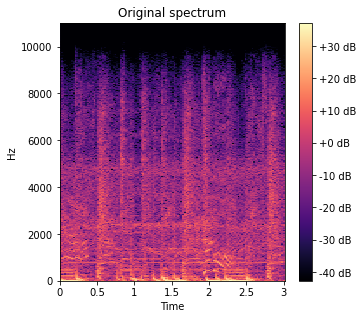

In [78]:
mgr.plot_spectrogram(X_db, 22050, 512, size=(5.05,4.75), title="Original spectrum")

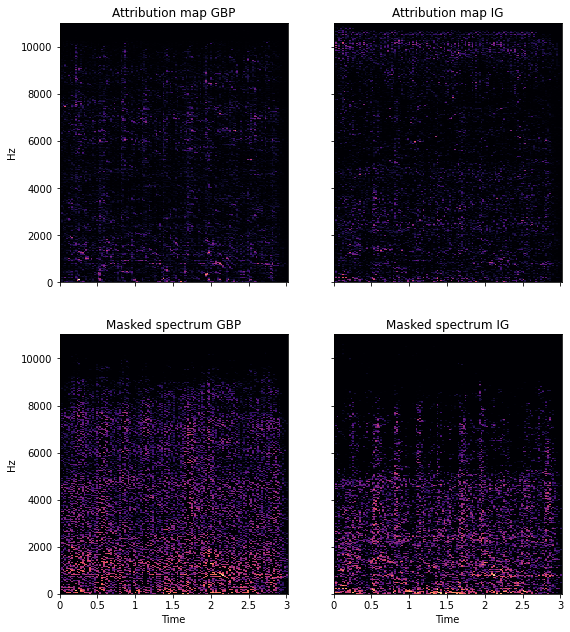

In [80]:
plot_spectrogram(np_ultimate(np.log1p(pos_sal_gbp)), np_ultimate(np.log1p(pos_sal_ig)), X_masked_gbp, X_masked_ig, 22050, 512)

# Guided Gradients

In [73]:
model = mgr.load_model("./data/saved_models/model-spectro10-epoch15-batch64_512-norm.pth").cpu().eval()
gbp = mgr.GuidedBackprop(model)
guided_grads = gbp.generate_gradients(X_test[759].unsqueeze(0), prediction)
pos_sal_gbp, neg_sal_gbp = mgr.get_positive_negative_saliency(guided_grads)
X_masked_gbp = X_amplitude * neg_sal_gbp
reconstruction_gbp = librosa.griffinlim(X_masked_gbp, hop_length=512, win_length=1024)
X_masked_gbp = librosa.amplitude_to_db(X_masked_gbp)

In [ ]:
mgr.plot_spectrogram(np.log1p(pos_sal_gbp), 22050, 512)

In [ ]:
mgr.plot_spectrogram(X_db, 22050, 512)

In [ ]:
mgr.plot_spectrogram(X_masked_gbp, 22050, 512, title="GBP masked spectrum")

In [74]:
ipd.Audio(reconstruction_gbp, rate=22050)
# sf.write("./results/sample_masked_gbp.wav", reconstruction_gbp, 22050)

# Integrated Gradients

In [76]:
model = mgr.load_model("./data/saved_models/model-spectro10-epoch15-batch64_512-norm.pth").cpu().eval()
baseline = torch.zeros(1, 1, 513, 130)
ig = IntegratedGradients(model)
integrated_grads = ig.attribute(X_test[759].unsqueeze(0), baseline, prediction).squeeze().numpy()
pos_sal_ig, _ = mgr.get_positive_negative_saliency(integrated_grads)
X_masked_ig = X_amplitude * pos_sal_ig
reconstruction_ig = librosa.griffinlim(X_masked_ig, hop_length=512, win_length=1024)
X_masked_ig = librosa.amplitude_to_db(X_masked_ig)

In [ ]:
mgr.plot_spectrogram(np.log1p(pos_sal_ig), 22050, 512)

In [ ]:
mgr.plot_spectrogram(X_db, 22050, 512)

In [ ]:
mgr.plot_spectrogram(X_masked_ig, 22050, 512, title="IG masked spectrum")

In [77]:
ipd.Audio(reconstruction_ig, rate=22050)
# sf.write("./results/sample_masked_ig.wav", reconstruction_ig, 22050)

In [12]:
def np_ultimate(x):
    return (np.log1p(np.log1p(x)) / (np.log1p(np.log1p(x)).max()))

In [13]:
import matplotlib.pyplot as plt

def plot_spectrogram(Y1, Y2, Y3, Y4, sr, hop_length, y_axis="linear", cmap="magma", size=(9, 10.5)):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)
    
    img1 = librosa.display.specshow(Y1, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis, ax=ax[0,0], cmap=cmap)
    ax[0,0].set(title='Attribution map GBP')
    
    img2 = librosa.display.specshow(Y2, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis, ax=ax[0,1], cmap=cmap)
    ax[0,1].set(title='Attribution map IG')
        
    img3 = librosa.display.specshow(Y3, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis, ax=ax[1,0], cmap=cmap)
    ax[1,0].set(title='Masked spectrum GBP')
    
    img4 = librosa.display.specshow(Y4, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis, ax=ax[1,1], cmap=cmap)
    ax[1,1].set(title='Masked spectrum IG')
    
    for ax_i in ax:
        for ax_j in ax_i:
            ax_j.label_outer()

    fig.set_size_inches(size)